In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import os.path
import pandas
import src
import sklearn
import os
import scipy
import scipy.stats

In [3]:
# import seaborn
# seaborn.set_palette("colorblind")

In [4]:
os.chdir('..')

In [5]:
args = dict(level='file', force=False, model='lda', source=['release', 'changeset', 'temporal'])

model_config, model_config_string = src.main.get_default_model_config(args)
args.update({'model_config': model_config, 'model_config_string': model_config_string})

changeset_config, changeset_config_string = src.main.get_default_changeset_config()
args.update({'changeset_config': changeset_config, 'changeset_config_string': changeset_config_string})

projects = src.common.load_projects(args)
projects

[Project(name='tika', printable_name='Tika v1.8', version='v1.8', ref='refs/tags/1.8', data_path='data/tika/', full_path='data/tika/v1.8/', src_path='data/tika/v1.8/src/', source=['release', 'changeset', 'temporal'], model_config_string=u'batch-0.002-0.5-0.002-1000-1000-500-1.0-1', force=False, level='file', changeset_config_string=u'True-True-False-True', model='lda', model_config={'passes': 1, 'eta': 0.002, 'num_topics': 500, 'iterations': 1000, 'decay': 0.5, 'algorithm': 'batch', 'alpha': 0.002, 'offset': 1.0, 'max_bound_iterations': 1000}, changeset_config={'include_removals': True, 'include_context': True, 'include_message': False, 'include_additions': True}),
 Project(name='pig', printable_name='Pig v0.14.0', version='v0.14.0', ref='refs/tags/release-0.14.0', data_path='data/pig/', full_path='data/pig/v0.14.0/', src_path='data/pig/v0.14.0/src/', source=['release', 'changeset', 'temporal'], model_config_string=u'batch-0.002-0.5-0.002-1000-1000-500-1.0-1', force=False, level='file'

In [6]:
data = dict()
csvs = dict()
for project in projects:
    ownership = src.ownership.read_ownership(project)
    devs = set()
    for v in ownership.values():
        devs.update(v.keys())
        
    goldsets = pandas.read_csv(os.path.join(project.full_path, 'goldset-info.csv'))
    changes = pandas.read_csv(os.path.join(project.full_path, 'changeset-info.csv'))
    release = pandas.read_csv(os.path.join(project.full_path, 'releasefile-info.csv'))
    queries = pandas.read_csv(os.path.join(project.full_path, 'queries-info.csv'))
    info = {"Developers": len(devs), "Changesets": len(changes), "Files": len(release), "Issues": len(queries)}
    data[project.printable_name] = info
    
    csvs[project.name] = {'g': goldsets, 'c': changes, 'r': release, 'q': queries, 'd': devs, 'o': ownership}


In [7]:
df = pandas.DataFrame(data)
df['Total'] = df.T.sum()
df.T

,Changesets,Developers,Files,Issues
BookKeeper v4.3.0,574,5,843,164
Mahout v0.10.0,3283,38,1556,133
OpenJPA v2.3.0,4616,26,4968,137
Pig v0.14.0,2584,28,2098,222
Tika v1.8,2469,26,954,40
ZooKeeper v3.5.0,1245,16,927,359
Total,14771,139,11346,1055


In [8]:
with open(os.path.expanduser('~/git/dissertation/tables/subjects.tex'), 'w') as f:
    header = ["\\begin{table}",
              "\\centering",
              "\\caption{Subject system corpora and dataset sizes}",
              "\\label{table:subjects}"]
    f.write('\n'.join(header) + '\n')
    latex = df.T.to_latex(columns=["Developers", "Files", "Changesets", "Issues"]).splitlines()
    latex.insert(-3, '\\midrule')
    f.write('\n'.join(latex))
    f.write("\n\\end{table}\n")

In [9]:
for project in projects:
    print(project.name, 'q total ',  csvs[project.name]['q'].total_words.sum() / len(csvs[project.name]['q']))
    print(project.name, 'q unique', csvs[project.name]['q'].unique_words.sum() / len(csvs[project.name]['q']))
    print()
    print(project.name, 'c total ',  csvs[project.name]['c'].total_words.sum() / len(csvs[project.name]['c']))
    print(project.name, 'c unique', csvs[project.name]['c'].unique_words.sum() / len(csvs[project.name]['c']))
    print()
    print(project.name, 'r total ',  csvs[project.name]['r'].total_words.sum() / len(csvs[project.name]['r']))
    print(project.name, 'r unique', csvs[project.name]['r'].unique_words.sum() / len(csvs[project.name]['r']))
    print('********************')

tika q total  72
tika q unique 35

tika c total  900
tika c unique 130

tika r total  658
tika r unique 187
********************
pig q total  79
pig q unique 28

pig c total  3785
pig c unique 159

pig r total  746
pig r unique 117
********************
bookkeeper q total  42
bookkeeper q unique 21

bookkeeper c total  4127
bookkeeper c unique 206

bookkeeper r total  663
bookkeeper r unique 122
********************
openjpa q total  113
openjpa q unique 41

openjpa c total  1567
openjpa c unique 102

openjpa r total  402
openjpa r unique 96
********************
mahout q total  54
mahout q unique 28

mahout c total  2502
mahout c unique 142

mahout r total  614
mahout r unique 114
********************
zookeeper q total  79
zookeeper q unique 33

zookeeper c total  2258
zookeeper c unique 287

zookeeper r total  622
zookeeper r unique 139
********************


In [10]:
pigo = pandas.DataFrame(csvs['pig']['o'])
jpao = pandas.DataFrame(csvs['openjpa']['o'])
booko = pandas.DataFrame(csvs['bookkeeper']['o'])

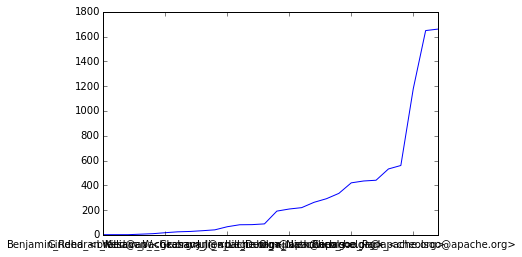

In [11]:
pigo.T.describe().T.sort("count")["count"].plot()

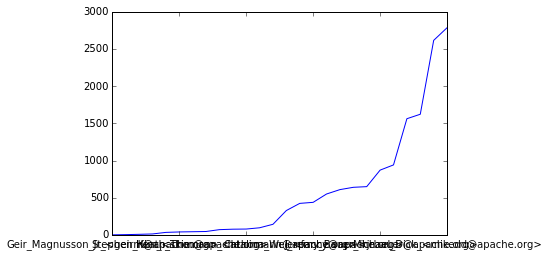

In [12]:
jpao.T.describe().T.sort("count")["count"].plot()

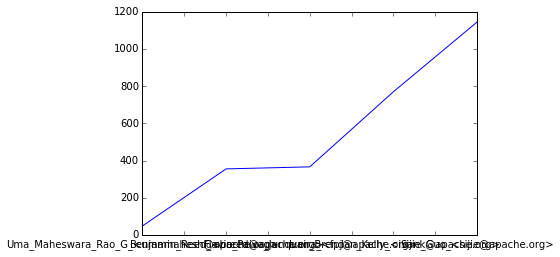

In [13]:
booko.T.describe().T.sort("count")["count"].plot()

In [14]:
def plot_ownership(data):
    m = dict()
    for each in data:
        z = data[each].argmax()
        if z not in m:
            m[z] = list()
        m[z].append(each)

    zz = pandas.Series([len(v) for v in m.values()], index=[k for k in m])
    zz.sort()
    zz.plot()
    return zz


Uma_Maheswara_Rao_G_<umamahesh@apache.org>    0.000552
Flavio_Paiva_Junqueira_<fpj@apache.org>       0.082320
Benjamin_Reed_<breed@apache.org>              0.093370
Ivan_Brendan_Kelly_<ivank@apache.org>         0.333149
Sijie_Guo_<sijie@apache.org>                  0.490608
dtype: float64

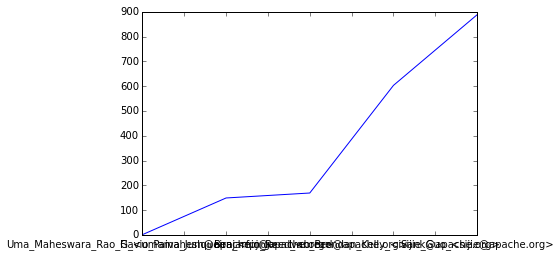

In [15]:
zz = plot_ownership(booko)
zz / zz.sum()

Jeff_Zhang_<zjffdu@apache.org>                      0.000293
Giridharan_Kesavan_<gkesavan@apache.org>            0.000586
Raghu_Angadi_<rangadi@apache.org>                   0.000586
Prashant_Kommireddi_<prkommireddi@apache.org>       0.000586
Koji_Noguchi_<knoguchi@apache.org>                  0.000879
Gianmarco_De_Francisci_Morales_<gdfm@apache.org>    0.000879
Xuefu_Zhang_<xuefu@apache.org>                      0.000879
Ashutosh_Chauhan_<hashutosh@apache.org>             0.001758
William_W._Graham_Jr_<billgraham@apache.org>        0.003223
Aniket_Namadeo_Mokashi_<aniket486@apache.org>       0.004981
Julien_Le_Dem_<julien@apache.org>                   0.005860
Jonathan_Coveney_<jcoveney@apache.org>              0.007618
Richard_Ding_<rding@apache.org>                     0.012892
Santhosh_Muthur_Srinivasan_<sms@apache.org>         0.016994
Pradeep_Kamath_<pradeepkth@apache.org>              0.019045
Yan_Zhou_<yanz@apache.org>                          0.024319
Dmitriy_V._Ryaboy_<dvrya

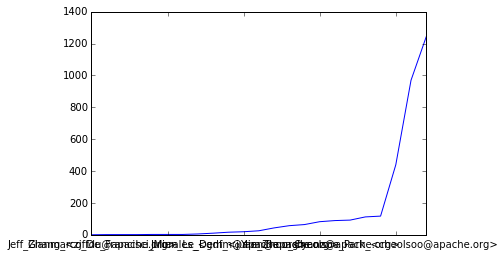

In [16]:
zz = plot_ownership(pigo)
zz / zz.sum()

Tim_McConnell_<mcconne@apache.org>          0.000160
Stephen_Kim_<skim@apache.org>               0.000160
Geir_Magnusson_Jr_<geirm@apache.org>        0.000160
Craig_Russell_<clr@apache.org>              0.001602
Jody_Grassel_<jgrassel@apache.org>          0.001762
Milosz_Tylenda_<mtylenda@apache.org>        0.002563
David_Ezzio_<dezzio@apache.org>             0.002723
Heath_Thomann_<hthomann@apache.org>         0.004486
David_J._Wisneski_<wisneskid@apache.org>    0.004646
Dianne_E._Richards_<dianner@apache.org>     0.006248
Kevin_W._Sutter_<kwsutter@apache.org>       0.008010
Mark_Struberg_<struberg@apache.org>         0.019225
Richard_G._Curtis_<curtisr7@apache.org>     0.021628
A._Abram_White_<awhite@apache.org>          0.026113
Albert_Lee_<allee8285@apache.org>           0.029157
Catalina_Wei_<fancy@apache.org>             0.036687
Fay_Wang_<faywang@apache.org>               0.048542
Marc_Prud'hommeaux_<mprudhom@apache.org>    0.069369
Jeremy_Bauer_<jrbauer@apache.org>           0.

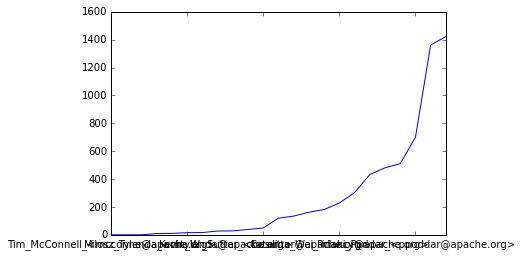

In [17]:
zz = plot_ownership(jpao)
zz / zz.sum()

# Triage

In [18]:
ALL_ORDER = ["Snapshot", "Changesets", "Historical"]
RQ1_ORDER = ["Snapshot", "Changesets"]
RQ2_ORDER = ["Changesets", "Historical"]

In [19]:
datarank = dict()
for project in projects:
    results = src.triage.run_experiment(project) 
    x, y = src.common.merge_first_rels(results['changeset'], results['release'], ignore=True)
    _, z = src.common.merge_first_rels(results['changeset'], results['temporal'], ignore=True)
    print(len(x), len(y), len(z))
    datarank[project.printable_name] = {'Changesets': pandas.Series(x),
                                        'Snapshot': pandas.Series(y),
                                        'Historical': pandas.Series(z)}

tpanel = pandas.Panel(datarank)

40 40 40
222 222 222
164 164 164
137 137 137
133 133 133
359 359 359


In [65]:
datarank = dict()
for project in projects:
    results = src.feature_location.run_experiment(project) 
    x, y = src.common.merge_first_rels(results['changeset'], results['release'], ignore=True)
    _, z = src.common.merge_first_rels(results['changeset'], results['temporal'], ignore=True)
    print(len(x), len(y), len(z))
    datarank[project.printable_name] = {'Changesets': pandas.Series(x),
                                        'Snapshot': pandas.Series(y),
                                        'Historical': pandas.Series(z)}

fpanel = pandas.Panel(datarank)

36 36 36
174 174 174
143 143 143
131 131 131
50 50 50
241 241 241


In [108]:
FIG_TEX="""
\\begin{figure}
\\centering
\\includegraphics[height=0.4\\textheight]{%s}
\\caption{%s: %s effectiveness measures for %s}
\\label{fig:%s}
\\end{figure}
"""

def plot_panel(panel, order, name, kind):
    size = (len(order)*1.6, 4.5)
    fontsize = None
    widths = 0.3
    lower = 0
    kinds = {"flt": "Feature Location", "dit": "Developer Identification"}
    rqs = {"flt": {"rq1": "RQ 3.3.1", "rq2": "RQ 3.3.2", "all": "Overview"}, "dit": {"rq1": "RQ 3.4.1", "rq2": "RQ 3.4.2", "all": "Overview"}}


    allt = pandas.DataFrame()
    for each in panel:
        allt = allt.append(tpanel[each], ignore_index=True)

        upper = panel[each][order].max().max()+1
        panel[each].plot(kind='box',
                         fontsize=fontsize,
                         figsize=size,
                         widths=widths,
                         ylim=(lower, upper),
                         y=order)
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        short_each = each.lower().split(' ')[0]
        fig_name = 'figures/%s/%s_%s' % (kind, name, short_each)
        path = os.path.expanduser('~/git/dissertation/') + fig_name
        plt.savefig(path + ".pdf", dpi=300)
        
        with open(path + ".tex", "wt") as f:
            figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
            f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], each, figlabel))
        
    upper = allt.max().max()+1
    allt.plot(kind='box', figsize=(4,1.5), grid=False, vert=False, y=list(reversed(order)))
    plt.tight_layout()
    short_each = "tiny"
    fig_name = 'figures/%s/%s_%s' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], "all subject systems", figlabel))
    
    allt.plot(kind='box',
               fontsize=fontsize,

              figsize=size,
              widths=widths,
              ylim=(lower, upper),
              y=order)
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    short_each = "overview"
    fig_name = 'figures/%s/%s_%s' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)
    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], "all subject systems", figlabel))

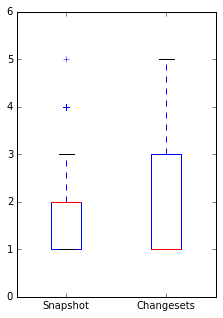

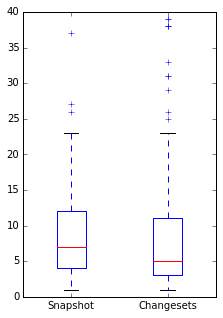

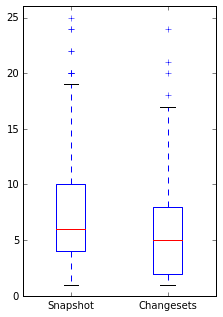

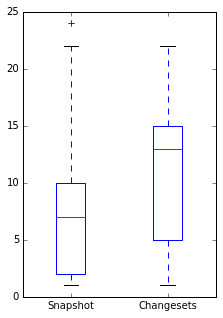

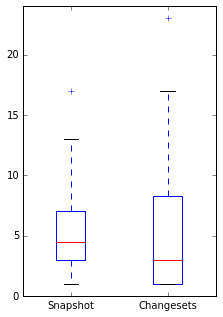

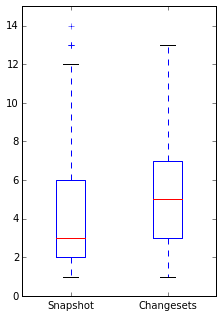

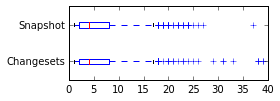

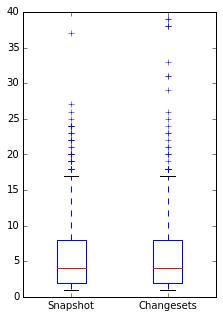

In [109]:
plot_panel(tpanel, RQ1_ORDER, "rq1", "dit")

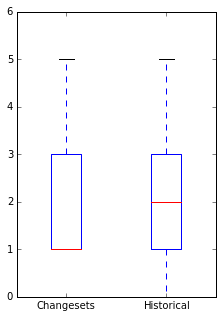

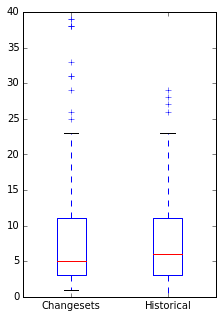

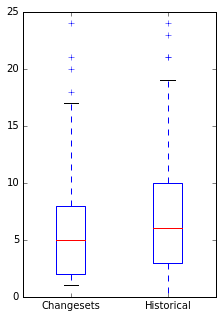

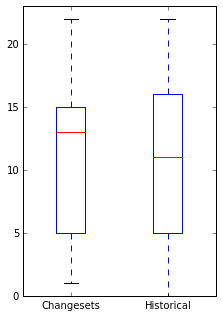

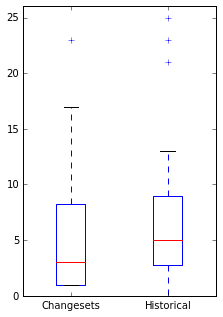

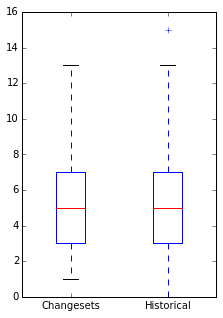

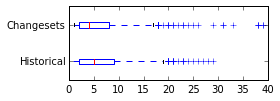

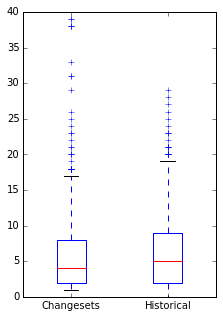

In [110]:
plot_panel(tpanel, RQ2_ORDER, "rq2", "dit")

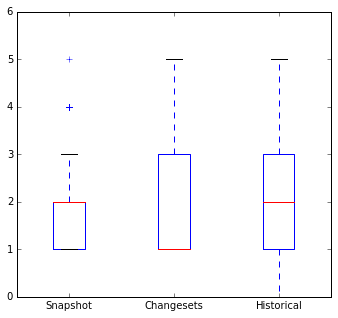

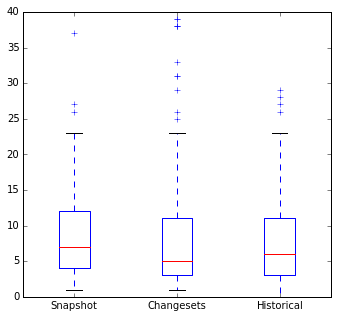

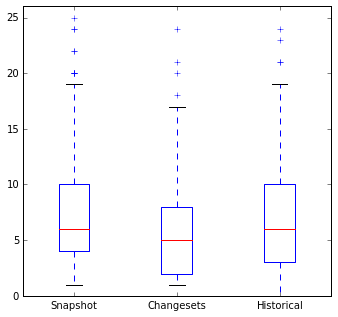

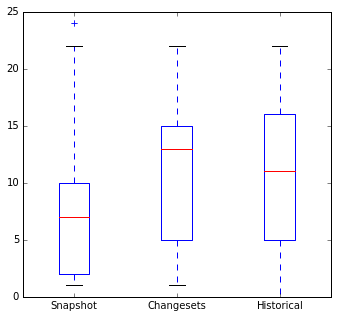

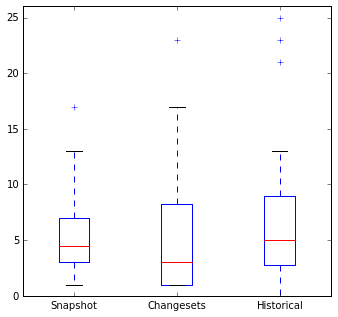

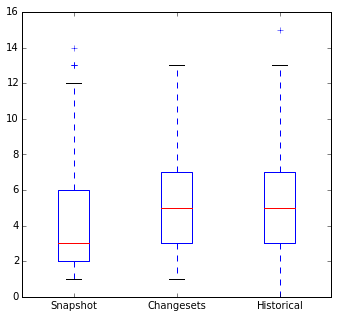

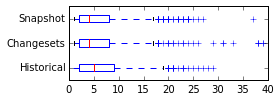

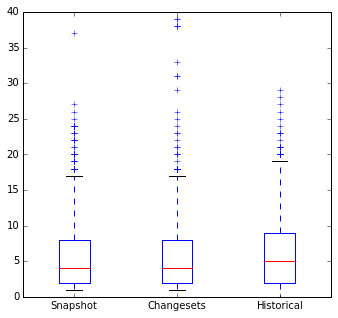

In [111]:
plot_panel(tpanel, ALL_ORDER, "all", "dit")

# Feature loc

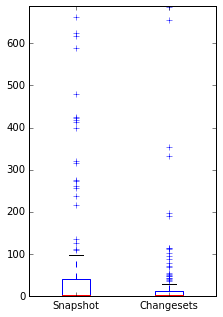

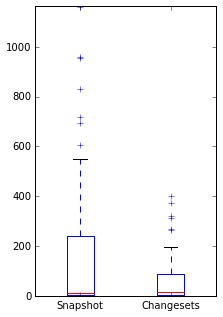

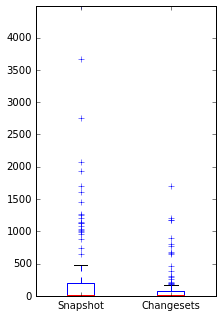

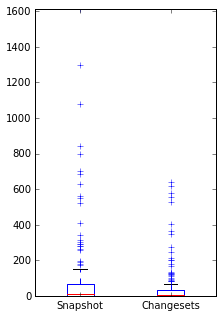

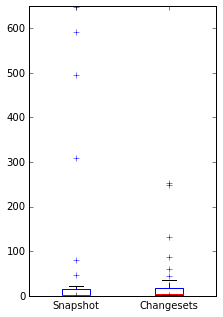

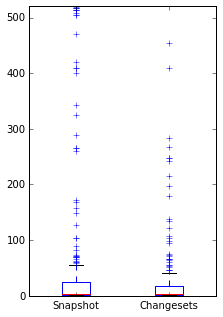

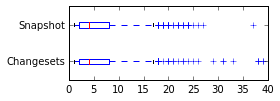

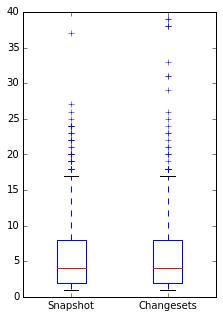

In [112]:
plot_panel(fpanel, RQ1_ORDER, "rq1", "flt")

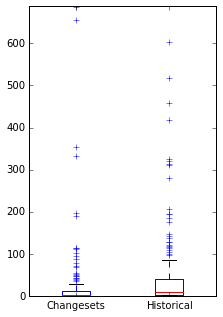

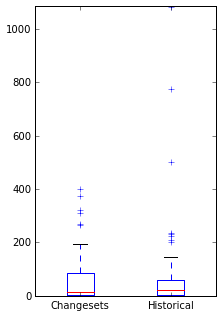

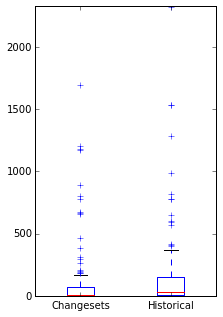

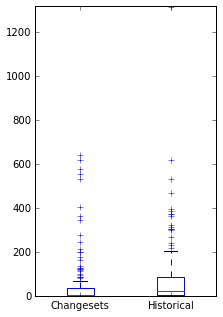

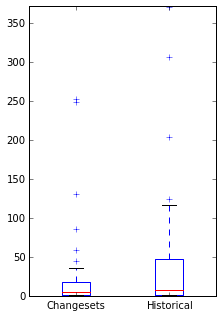

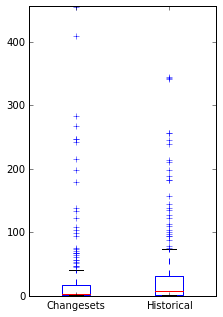

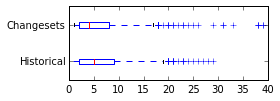

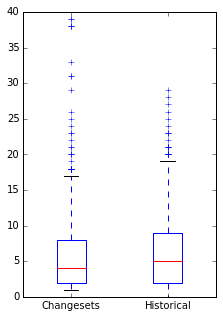

In [113]:
plot_panel(fpanel, RQ2_ORDER, "rq2", "flt")

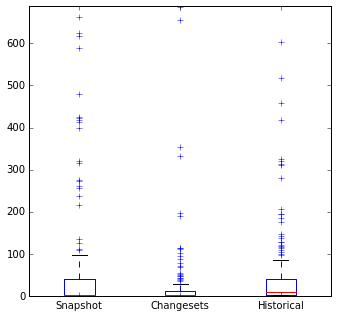

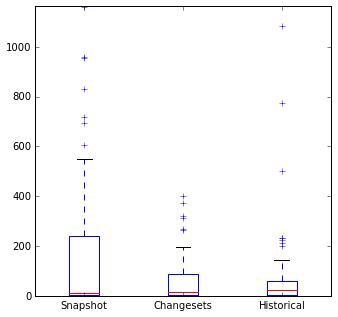

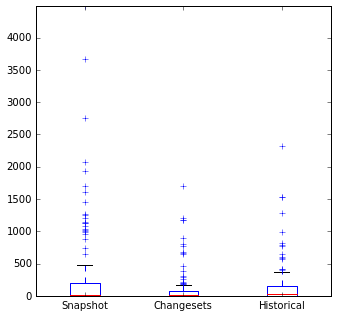

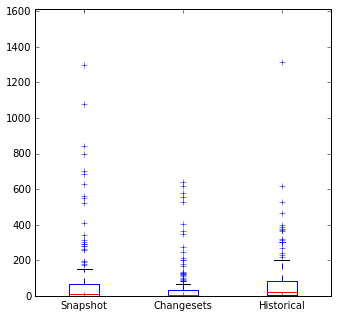

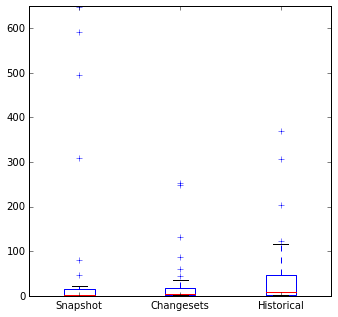

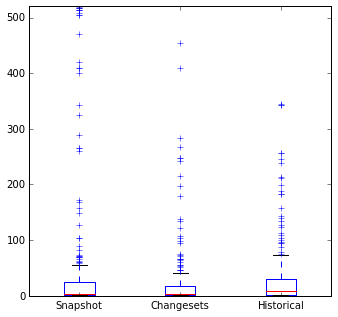

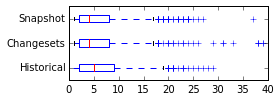

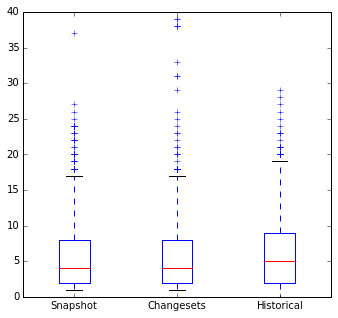

In [114]:
plot_panel(fpanel, ALL_ORDER, "all", "flt")